In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from queue import PriorityQueue
from sklearn.neighbors import NearestNeighbors
from numba import jit

%matplotlib inline

In [2]:
data_file = "./data/tsp_150_2"
data = pd.read_csv(data_file, sep=" ", names=["x", "y"], dtype={"x":float, "y":float})

In [3]:
data.head()

,x,y
0,150.0,NaN
1,3099.0,173.0
2,2178.0,978.0
3,138.0,1610.0
4,2082.0,1753.0


In [4]:
n = int(data["x"][0])

In [21]:
class Vertex:
    
    def __init__(self, index, x, y):
        self.index = index
        self.x = x
        self.y = y

class Distance(object):

    def __init__(self, solution, distance):
        self.solution = solution
        self.distance = distance

    def __lt__(self, other):
        return self.distance < other.distance
    
class VertexDistance(object):

    def __init__(self, index, distance):
        self.index = index
        self.distance = distance
        
    def __lt__(self, other):
        return self.distance < other.distance


vertices = []
points = []
for i in range(1, n+1):
    vertices.append(Vertex(i-1, data["x"][i], data["y"][i]))
    points.append((data["x"][i], data["y"][i]))

In [22]:
def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    
    """

    # Unpack the primary TSP path and transform it into a list of ordered 
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])
    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]), 
                    head_width = a_scale, color = 'r', 
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale, 
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(-1, max(x)*1.1)
    plt.ylim(-1, max(y)*1.1)
    plt.show()

In [44]:
def euclidean_distance(vertex_1, vertex_2):
    return np.sqrt( np.square(vertex_1.x - vertex_2.x)  + np.square(vertex_1.y - vertex_2.y) )

def objective_function(route):
    """
    Assume vertices is route starting and ending at same vertex e.g.
    [1, 3, 2, 0, 1]
    """
    head_route = route[0:(len(route)-1)]
    tail_route = route[1:]
    combined_route = zip(head_route, tail_route)
    dist_sum = 0.0
    for vertex_pair in combined_route:
        dist_sum += euclidean_distance(vertex_pair[0], vertex_pair[1])
    return dist_sum
    
def is_valid_hamiltonian_cycle(route, n):
    # Ensure it starts and ends at same node
    start_and_end = route[0] == route[-1]
    
    # Need to ensure all vertices 0,..,n-1 are present
    all_index = list(range(0, n))
    indexes = sorted(list(set([vertex.index for vertex in route])))
    index_present = all_index == indexes
    
    return start_and_end and index_present

def tour_string(vertices):
    return " ".join([str(i.index) for i in vertices])

def tour_list(vertices):
    return [i.index for i in vertices]

# Improved NN approach

@jit
def nearest_neighbour(vertices, n, max_search=0):
    remaining_indexes = set(range(0, n))
    starting_vertex = np.random.randint(0, n)
    remaining_indexes.remove(starting_vertex)
    used_indexes = set(remaining_indexes)
    tour = [vertices[starting_vertex]]
    
    while len(remaining_indexes) > 0:
        cur_vertex = tour[-1]
        solution_queue = PriorityQueue()
        
        num_checked = 0
        for i in remaining_indexes:
            dist = euclidean_distance(cur_vertex, vertices[i])
            solution_queue.put(VertexDistance(i, dist))
            num_checked += 1
            
            if (max_search != 0 and num_checked > max_search):
                break
            
        # Select the shortest distance
        nearest = solution_queue.get()
        
        # Update the tour
        tour.append(vertices[nearest.index])
        remaining_indexes.remove(nearest.index)
        
    # Add final node to tour
    tour.append(tour[0])
        
    return tour

@jit
def two_opt_rand(vertices, n):
    
    route = nearest_neighbour(vertices, n)
    cur_distance = objective_function(route)
    while True:
        print("here")

        # Randomely pick an edge
        i = np.random.randint(1, n)
       
        solution_queue = PriorityQueue()
        for j in range(i+1, len(route)):
            new_route = route[:]
            new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
            
            assert(is_valid_hamiltonian_cycle(new_route, n))
            value = objective_function(new_route)
            solution_queue.put(Distance(new_route, value))
            
        best_move = solution_queue.get()
        best_distance = best_move.distance
        
        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move.solution
        else:
            break
            
    return route

@jit
def two_opt_full(vertices, n):
        
    route = nearest_neighbour(vertices, n)
    cur_distance = objective_function(route)
    while True:
        print(cur_distance)

        # Randomely pick an edge
        solution_queue = PriorityQueue()
        for i in range(1, n):
            for j in range(i+1, len(route)):
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2-opt Swap
    
                assert(is_valid_hamiltonian_cycle(new_route, n))
                value = objective_function(new_route)
                solution_queue.put(Distance(new_route, value))

        best_move = solution_queue.get()
        best_distance = best_move.distance

        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move.solution
        else:
            break
            
    return route

# 3 opt

In [45]:
a = two_opt_full(vertices, n)

32796.4433288
31763.1540048
31125.4619579
30780.2465914
30467.6173828
30196.139732
29934.496719
29736.9203152
29552.56439
29381.2906174
29220.3332202
29059.6163054
28912.1997378
28765.1916891
28642.2314949
28520.6485187
28413.0083737
28306.9092676
28205.6910851
28127.4890458
28050.1118566
27987.4937934
27927.8295064
27794.5134596
27741.0085249
27725.2109599
27715.731963
27668.6011845
27660.1851723
27592.3275228
27233.6030917
27221.6075375
27216.5369096
27211.4972208
27208.0930986
27208.0930986


In [41]:
objective_function(a)

35678.642301746622

In [42]:
print(tour_list(a))

[60, 11, 8, 122, 27, 52, 118, 137, 90, 59, 70, 51, 125, 44, 111, 103, 92, 123, 17, 67, 88, 110, 131, 148, 84, 16, 23, 65, 93, 29, 140, 83, 2, 6, 100, 135, 56, 106, 41, 98, 66, 120, 49, 61, 127, 75, 9, 101, 89, 87, 3, 34, 138, 132, 28, 53, 26, 97, 76, 109, 142, 104, 39, 1, 4, 71, 139, 54, 31, 114, 86, 40, 78, 134, 64, 143, 42, 147, 77, 133, 115, 13, 46, 95, 63, 55, 0, 45, 35, 144, 15, 47, 18, 19, 124, 57, 10, 117, 79, 43, 130, 25, 50, 38, 32, 37, 62, 136, 7, 146, 48, 145, 112, 113, 102, 12, 72, 22, 33, 69, 108, 14, 99, 91, 30, 82, 36, 96, 149, 58, 128, 73, 80, 121, 105, 141, 116, 129, 94, 81, 85, 126, 74, 20, 68, 21, 5, 119, 107, 24, 60]


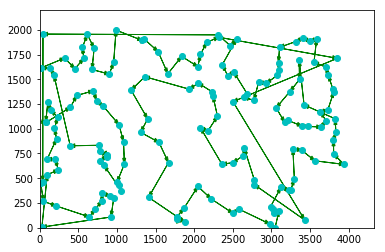

In [43]:
plotTSP([tour_list(a)[:-1]], points)

In [102]:
print(objective_function(a))

4.0


ValueError: 'vertices' must be a 2D list or array with shape Nx2

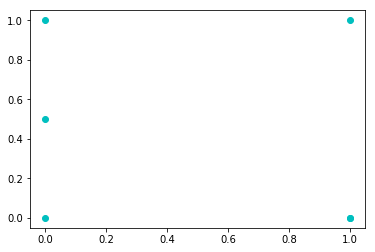

In [72]:
plotTSP([tour_list(a)], points)

In [71]:
points

[(0.0, 0.0), (0.0, 0.5), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0)]

In [141]:
a[0:3]

[1, 2, 3]

In [157]:
max(0,2)

2

In [178]:
a[0:0]

[]

In [61]:
nbrs = NearestNeighbors(n_neighbors=300, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(points)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 150, n_neighbors = 300

In [58]:
indices

array([[  0,  45,  35, ...,   2,   6,  81],
       [  1,  39,   4, ...,   6,  81,  11],
       [  2,  83,   6, ..., 130,  79, 117],
       ..., 
       [147,  77,  42, ...,  81, 108, 132],
       [148, 131, 110, ...,  12, 108, 132],
       [149,  58,  96, ..., 126,  74,  11]])

In [59]:
distances

array([[    0.        ,    67.35725648,    81.58431222, ...,
         3291.274829  ,  3398.97999406,  3538.6144181 ],
       [    0.        ,   102.45974819,   193.8478785 , ...,
         2248.70118068,  2348.75839541,  2358.59810057],
       [    0.        ,    82.66196223,   116.21101497, ...,
         3753.1877118 ,  3768.38426915,  3922.81799221],
       ..., 
       [    0.        ,    17.72004515,   103.74005976, ...,
         2549.38914252,  2563.98322927,  2632.937523  ],
       [    0.        ,    62.16912417,   102.90286682, ...,
         2927.20156463,  2958.57279782,  3099.61691181],
       [    0.        ,    98.85848471,   166.58031096, ...,
         3087.16471864,  3121.55233818,  3247.21804011]])

In [60]:
n

150